In [ ]:
# Took inspiration from https://www.youtube.com/watch?v=yVYBSvbOWu4&ab_channel=ECSLLab

In [136]:
# Cartpole Q-Learning
import gym                                          # Environment framework
from math import radians, log10                     # Two math functions
import numpy as np                                  # Advanced math + syntactic sugar
from pandas import Series                           # To make one piece of math easier
from sklearn.preprocessing import KBinsDiscretizer  # Discretization made easy
import matplotlib.pyplot as plt                     # Graph generation
import cv2                                          # Video export code
import time                                         # Stopwatch for training time

In [137]:
# Control Panel
SEED = 100
n_episodes = 1001               # Number of total attempts
capture_interval = 500          # Export a video every N iterations
reward_update_interval = 100    # (debug) print out total reward for every Nth iteration
export_fps = 30                 # frames per second of video export
 
learning_coeff = 150            # Large values -> Slower decay of willingness to learn/explore
exploration_coeff = 150         # You'll need to tweak both of these until you get good learning

In [138]:
# Setup
# Initialize environment
env = gym.make("CartPole-v1", render_mode='rgb_array')  # 'human' render mode takes too long
env.action_space.seed(SEED)                             # Initialize PRNG for gym
np.random.seed(SEED)                                    # For exploration reproducibility
env.reset(seed=SEED)                                    # And for the environment (must ONLY be passed ONCE)

(array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
 {})

In [139]:
# Initialize reward statistics for graphing later
graph_x = np.arange(n_episodes)
graph_y = np.zeros(n_episodes)

In [140]:
# Bin size configuration
n_bins = (12, 6, 12, 6)   # This number requires tweaking from task to task
lower_bounds = [env.observation_space.low[0], -0.25,            # Manual values are specified for parts of the
                env.observation_space.low[2], -radians(50)]     #   environment state that range from (-inf, inf)
upper_bounds = [env.observation_space.high[0], 0.25,            # You must choose such bounds manually
                env.observation_space.high[2], radians(50)]

In [141]:
# Supplemental Methods
# Discretization method
#   Takes in an array of continuous values representing the game state
#   and selects a bin for each value to be used in indexing the Q-Table
def discretizer(cart_position, cart_velocity, angle, pole_velocity):
    # This automatically determines the bin sizes and locations
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int,est.transform([[cart_position, cart_velocity, angle, pole_velocity]])[0]))
 
# Policy (how the AI chooses an action each iteration)
def policy(state):
    # Here, the robot uses a greedy strategy to select the best action it knows at the given moment
    return np.argmax(Q_table[state])
 
# Modulate the AI's 'curiosity' over time
def exploration_rate(n, min_rate = 0.05):
    return max(min_rate, min(1, 1.0 - log10((n + 1) / exploration_coeff)))
 
# Modulate the AI's willingness to learn over time
def learning_rate(n, min_rate = 0.01):
    return max(min_rate, min(1.0, 1.0 - log10((n + 1) / learning_coeff)))
 
# Q-value maths
def new_Q_value(reward, new_state, discount_factor = 1):
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [142]:
# Q-table initialization (all zeros across all bins)
Q_table = np.zeros(n_bins + (env.action_space.n,))
 
# Start timer to record training time (training only, not video export)
totalTime = 0
 
# Game loop
for i in range(n_episodes):
    # Reset environment for fresh run
    observation, info = env.reset()
    current_state, terminated, truncated = discretizer(*observation), False, False
 
    # Stat tracking
    total_reward_this_run = 0
 
    # Set up recording every capture interval
    out_video = None
    if i % capture_interval == 0:
        height, width, _ = env.render().shape
        out_video = cv2.VideoWriter(
            f"cartpole_iter_{i}.avi", 
            cv2.VideoWriter_fourcc(*'XVID'), 
            60, 
            (width, height))
 
    while not terminated and not truncated:
        # Start stopwatch for this iteration
        startTime = time.time()
 
        # Policy action
        action = policy(current_state)
        # Insert random action
        if np.random.random() < exploration_rate(i):
            action = env.action_space.sample()
        
        # Increment environment
        observation, reward, terminated, truncated, info = env.step(action)
        new_state = discretizer(*observation)
 
        # Update Q-table
        lr = learning_rate(i)
        learnt_value = new_Q_value(reward, new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
 
        # Update state
        current_state = new_state
 
        # Stats update
        total_reward_this_run += reward # max reward in this simulation is 1
 
        # Add training time for this iteration to accumulator
        endTime = time.time()
        totalTime += endTime - startTime
 
        # Render environment
        if i % capture_interval == 0:
            out_video.write(env.render())
    
    # Export video
    if i % capture_interval == 0:
        print(f"Writing video for iteration {i}...")
        out_video.release()
    
    # Debug output
    if i % reward_update_interval == 0:
        print(f"Total reward amassed during run {i}: {total_reward_this_run}")
 
    # Update graph data
    graph_y[i] = total_reward_this_run


Writing video for iteration 0...
Total reward amassed during run 0: 24.0
Total reward amassed during run 100: 11.0
Total reward amassed during run 200: 16.0
Total reward amassed during run 300: 52.0
Total reward amassed during run 400: 47.0
Writing video for iteration 500...
Total reward amassed during run 500: 77.0
Total reward amassed during run 600: 67.0
Total reward amassed during run 700: 130.0
Total reward amassed during run 800: 121.0
Total reward amassed during run 900: 34.0
Writing video for iteration 1000...
Total reward amassed during run 1000: 351.0


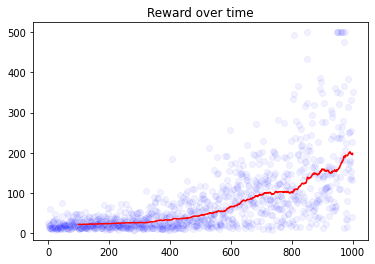


Total training time: 0:25


In [143]:
# Display graph of reward
plt.title("Reward over time")
plt.xlabel = "Attempt"
plt.ylabel = "Reward"
plt.plot(graph_x, graph_y, 
         color="blue", linestyle='', 
         marker='o', alpha=0.05, 
         label="Iter. Reward")
plt.plot(graph_x, Series(graph_y).rolling(100).mean().tolist(), 
         color="red", label="Rolling avg. (100 iter.)")
plt.show()
 
trainM, trainS = map(int,divmod(totalTime, 60))
print(f"\nTotal training time: {trainM}:{trainS:02}")
        
env.close()

In [123]:
from IPython.display import Video
Video("cartpole_iter_1000.avi")